# Pylops - Least squares migration with FD modelling

### Author: M.Ravasi

In this notebook I will show you how to perform least-squares migration with a Kirchoff modelling operator. In this case, however, the dataset that we try to invert is obtained using full-wavefield modelling (e.g. FD).

The modelling equation is therefore written as

$$ d(s, r, t) = -\frac{d^2w(t)}{dt^2} * \int_V G(x,s, t) G(r,x, t) r(x,z) dx dz$$

where $r(x, z)$ is our model and it represents the reflectivity at every location in the subsurface, $G(r,x, t)$ and $G(x,s, t)$ are the Green's functions from source to subsurface to receiver and finally $w$ is the wavelet (note that we need to use the second derivative of the wavelet (this comes from the LS equation - in frequency domain it has a $\omega^2$ in front.

In a matrix for

$$ \mathbf{d} = \mathbf{W} \mathbf{G}_s \mathbf{G}_r \mathbf{r}
$$

where $\mathbf{G}_s$ and $\mathbf{G}_r$ are the two propagators, which we implement here using an high-frequency approximation. We will both look at the case where we ignore amplitudes (therefore we have a kinematic-only Kirchhoff operator) as well as the case we take them into account.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway import AcousticWave2D
from pylops.waveeqprocessing.lsm import LSM
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

from examples.seismic import Model
from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Receiver
from examples.seismic import plot_velocity, plot_shotrecord

## Velocity model

Lets' create a model and geometry

In [2]:
# Velocity Model
data_path = "/Users/ravasim/Desktop/KAUST/OpenSource/devito/examples/seismic/mrava_codes/lsm/MODEL_P-WAVE_VELOCITY.bin"

origshape = (1360, 280)
nx, nz = 301, 120
dx, dz = 12.5, 12.5
x, z = np.arange(nx)*dx, np.arange(nz)*dz

# Get true model
vel = np.fromfile(data_path, dtype='float32', sep="") # devito expects velocity to have km/s as units
vel = vel.reshape(origshape)[:nx,:nz]
v0 = sp.ndimage.gaussian_filter(vel, sigma=4)    

# Reflectivity
Dop = FirstDerivative((nx, nz), axis=1)
refl = Dop * vel

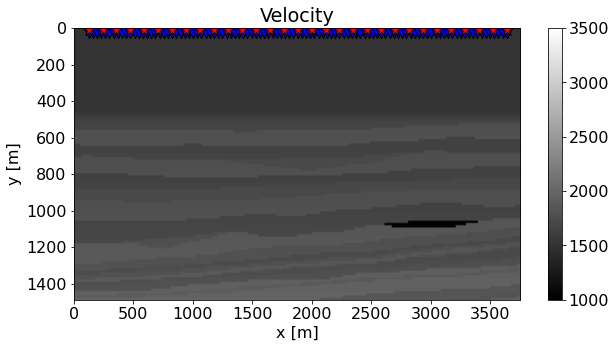

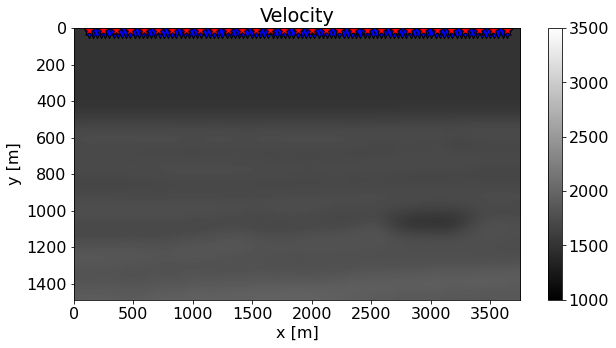

In [3]:
# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 31
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=1000, vmax=3500)
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(10,5))
im = plt.imshow(v0.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=1000, vmax=3500)
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1]);

## Data

Operator `initdamp` ran in 0.01 s
INFO: Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO: Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
INFO: Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO: Operator `pad_vp` ran in 0.01 s


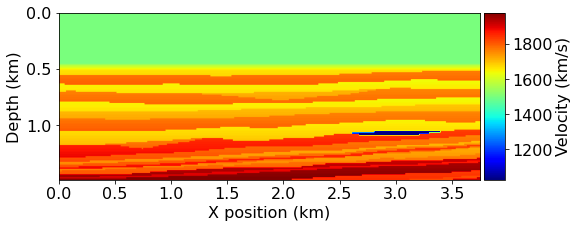

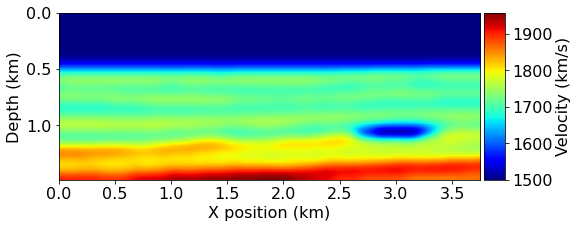

In [4]:
# modelling params
nbl=30 # Number of boundary layers around the domain
space_order=6 # Space order of the simulation
f0 = 15 # Source peak frequency
tn=3000 # Total simulation time

model = Model(space_order=space_order, vp=vel, origin=(0, 0), shape=(nx, nz),
              dtype=np.float32, spacing=(dx, dz), nbl=nbl, bcs="damp")

smooth_model = Model(space_order=space_order, vp=v0, origin=(0, 0), shape=(nx, nz),
                     dtype=np.float32, spacing=(dx, dz), nbl=nbl, bcs="damp")

plot_velocity(model)
plot_velocity(smooth_model)

In [5]:
Aop = AcousticWave2D((nx, nz), (0, 0), (dx, dz), vel,
                     sx, sz, rx, rz, 0., tn, 'Ricker',
                     space_order=6, nbl=100, f0=f0,
                     dtype="float32", name="A")

Operator `initdamp` ran in 0.01 s
INFO: Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO: Operator `pad_vp` ran in 0.01 s


In [6]:
nt = Aop.geometry.nt
dt = Aop.geometry.dt / 1e3
data = np.zeros((ns, nr, nt))

for isrc in range(ns):
    geometry = AcquisitionGeometry(
                Aop.model,
                Aop.geometry.rec_positions,
                Aop.geometry.src_positions[isrc, :],
                Aop.geometry.t0,
                Aop.geometry.tn,
                f0=Aop.geometry.f0,
                src_type=Aop.geometry.src_type)
    
    # model
    solver = AcousticWaveSolver(Aop.model, geometry, space_order=Aop.space_order)
    d = solver.forward()[0]
    d = d.resample(geometry.dt).data[:][: geometry.nt].T
    
    # direct wave masking
    direct = np.sqrt((sx[isrc]-rx)**2 + (sz[isrc]-rz)**2) / v0[0,0]
    directmask = np.zeros((nr, nt))
    for ir in range(nr):
        directmask[ir, int((direct[ir] + 0.2)//dt):] = 1.
    data[isrc] = d * directmask
    
# Remove wavelet
wcenter = np.argmax(geometry.src.data)
data = np.pad(data[..., wcenter:], ((0, 0), (0, 0), (0, wcenter)))

Operator `Forward` ran in 0.36 s
INFO: Operator `Forward` ran in 0.36 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.36 s
INFO: Operator `Forward` ran in 0.36 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in 0.35 s
Operator `Forward` ran in 0.35 s
INFO: Operator `Forward` ran in

Compute traveltimes

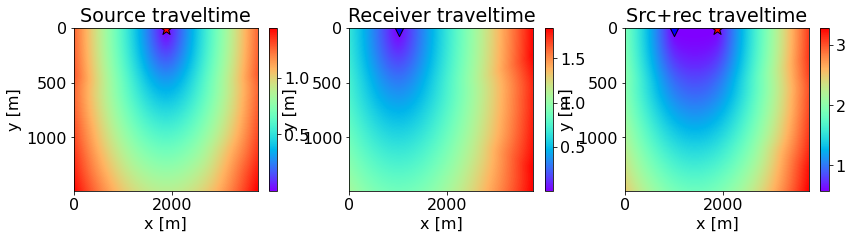

In [7]:
trav_eik, trav_srcs_eik, trav_recs_eik, dist_eik, _, _ = Kirchhoff._traveltime_table(z, x, sources, recs, v0, mode='eikonal')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

## Inversion

In [8]:
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=f0)

itrav = (np.floor(trav_eik/dt)).astype(np.int32)
travd = (trav_eik/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

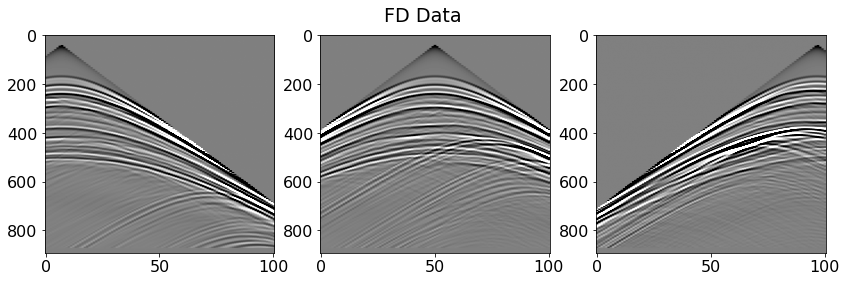

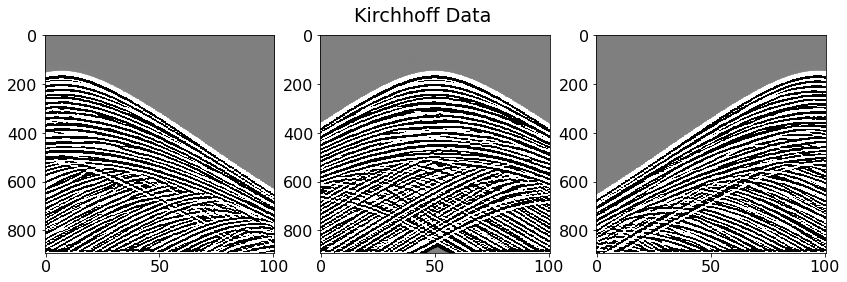

In [9]:
D2op = SecondDerivative(len(wav))
wavder = D2op * wav 
D2op = FirstDerivative(len(wav))
wavder = D2op * wav 
lsm = LSM(z, x, t, sources, recs, v0, wavder, wavc, mode='eikonal')
lsm.Demop = -lsm.Demop

data_kirch = lsm.Demop * refl.ravel()
data_kirch = data_kirch.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('FD Data')
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Kirchhoff Data')
axs[0].imshow(data_kirch[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data_kirch[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data_kirch[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight');

In [10]:
madj = lsm.Demop.H * data.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(data.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(data.ravel(), solver=fista, **dict(eps=1e-3, niter=100, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0][0].imshow(refl.T, cmap='gray', vmin=-100, vmax=100)
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray', vmin=-100, vmax=100)
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(-minv_sparse.T, cmap='gray', vmin=-100, vmax=100)
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$')

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :].T, cmap='gray', vmin=-1e-5, vmax=1e-5)
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T-dinv[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].set_title(r'$d_{inv}$ error')
axs[1].axis('tight')
axs[2].imshow(data[ns//2, :, :].T-dinv_sparse[ns//2, :, :].T, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_title(r'$d_{fista}$ error')
axs[2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax.imshow(refl.T, cmap='gray', vmin=-100, vmax=100)
ax.axis('tight')
ax.set_title(r'$m$')

fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax.imshow(-minv_sparse.T, cmap='gray', vmin=-100, vmax=100)
ax.axis('tight')
ax.set_title(r'$m_{FISTA}$');

## Velocity inversion

In [ ]:
# Modelling from velocity
LSMDop = lsm.Demop * Dop

data_kirch1 = LSMDop * vel.ravel()
data_kirch1 = data_kirch1.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('FD Data')
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Kirchhoff Data')
axs[0].imshow(data_kirch1[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data_kirch1[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data_kirch1[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight');

In [ ]:
# Regularized inversion
Regop = SecondDerivative(dims=(nx, nz), axis=0)
minv = regularized_inversion(LSMDop, data.ravel(), [Regop], 
                             x0=v0.ravel(),
                             epsRs=[4e-1], **dict(iter_lim=300, show=True))[0]
minv = minv.reshape((nx, nz))

dinv = lsm.Demop * refl.ravel()
dinv = dinv.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(dinv[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(dinv[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(dinv[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(v0.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='jet')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(minv.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{inv}$');

In [ ]:
# L-ADMM
sigma = 1e-1
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMDop, b=data.ravel(), sigma=1000, niter=20, warm=True) # FD data
#l2 = L2(Op=LSMDop, b=data.ravel(), sigma=1000, niter=20, warm=True) # Kirchoff data

Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMDop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99
mu = tau / L

mpd = LinearizedADMM(l2, l1, Gop, v0.ravel(), tau=tau, mu=mu, niter=100, show=True)[0]
dpd = LSMDop*mpd

mpd = mpd.reshape(nx, nz)
dpd = dpd.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(dpd[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(dpd[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(dpd[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(v0.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='jet')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(mpd.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{L-ADMM}$');

In [ ]:
# PD
sigma = 1e-1
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMDop, b=data.ravel(), sigma=1000, niter=20, warm=True) # FD data
#l2 = L2(Op=LSMDop, b=data.ravel(), sigma=1000, niter=20, warm=True) # Kirchoff data

Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMDop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Gop, v0.ravel(), tau=tau, mu=mu, niter=100, show=True)
dpd = LSMDop*mpd

mpd = mpd.reshape(nx, nz)
dpd = dpd.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(dpd[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(dpd[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(dpd[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(v0.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='jet')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(mpd.T, cmap='jet', vmin=1500, vmax=vel.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{PD}$');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.imshow(vel.T, cmap='jet', vmin=1500, vmax=vel.max())
ax.axis('tight')
ax.set_title(r'$m$')

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.imshow(mpd.T, cmap='jet', vmin=1500, vmax=vel.max())
ax.axis('tight')
ax.set_title(r'$m_{PD}$');